# 丢弃法(Dropout)
[dropout paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

考虑一个单隐层的多层感知机，其输入单元个数为4，隐藏单元个数为5，且隐藏单元$h_{i}(i = 1,2,...,5)$ 的计算表达式为  
$$ h_{i} = \phi \left(x_{1} w_{1i} + x_{2} w_{2i} + x_{3} w_{3i} + x_{4} w_{4i} + b_{i}\right)$$
这里 $\phi$ 是激活函数，$x_{1},...,x_{4}$是输入，隐藏单元 $i$的权重参数为 $w_{1i},...,w_{4i}$，偏差参数为 $b_{i}$。  
当我们对该隐藏层使用丢弃法时，该层隐藏单元将有一定的概率被丢掉。设丢弃概率为 $p$，那么有 $p$的概率 $h_{i}$ 会被清零，有$1-p$的概率 $h_{i}$ 会除以 $1-p$做拉伸。丢弃概率是丢弃法的超参数。  
具体来说，设随机变量 $\xi _{i}$ 为 0 和 1 的概率分别为 $p$ 和 $1-p$。使用丢弃法是我们计算新的隐藏单元 $h_{i}^{'}$  
$$ h_{i}^{'} = \frac{\xi _{i}}{1-p}h_{i}$$  
由于 $\mathbb E(\xi_{i}) = 1-p $, 因此  
$$ \mathbb E(h_{i}^{'}) = \frac{\mathbb E(\xi_{i})}{1-p}h_{i} = h_{i}$$  
即丢弃法不改变其输入的期望值。

如下图所示，其中 $h_{2}$ 和 $h_{5}$ 被清零，这时输出值的计算将不再依赖 $h_{2}$ 和 $h_{5}$，在反向传播时，与这两个隐藏单元相关的权重的梯度均为 0。  
![image](./image/model_selection/dropout.svg)  
由于在训练过程中隐藏神经元的丢弃是随机的，即 $h_{1},...,h_5$ 都有可能被清零，这样输出层的计算都无法过度依赖 $h_{1},...,h_5$ 中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。在测试模型时，将不使用丢弃法。

## 丢弃法的实现

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 定义一个dropout函数

In [2]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <=1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢掉
    if keep_prob == 0:
        return np.zeros_like(X)
    mask = np.random.uniform(0,1,X.shape) < keep_prob
    return mask * X /keep_prob

测试几个例子，其丢弃概率分别是$0,0.5$ 和 $1$

In [3]:
X = np.arange(16).reshape(2,8)
dropout(X,0)

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [4]:
dropout(X,0.5)

array([[ 0.,  2.,  0.,  6.,  8., 10.,  0.,  0.],
       [16.,  0., 20., 22., 24., 26., 28.,  0.]])

In [5]:
dropout(X, 1)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

## 神经网络中Dropout实验

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
# import matplotlib
# matplotlib.style.use('ggplot')
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.images.shape)
print(mnist.test.labels.shape)

(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


In [9]:
print(mnist.train.labels[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


#### 1、使用最简单的全连接神经网络实现数字分类（一个输入层，一个输出层）

In [10]:
# placeholder for input data
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# Weights
W = tf.Variable(tf.zeros([784, 10])) # 单层10分类
# Biasies
b = tf.Variable(tf.zeros([10]))

# output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(x,W)+b)

# loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_hat), reduction_indices=[1]))

# prediction
class_prediction = tf.argmax(y_hat,1)

# accuracy
correct_prediction = tf.equal(class_prediction, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# session
sess = tf.InteractiveSession()

In [11]:
# optimizer
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# init
init = tf.global_variables_initializer()
sess.run(init)

# train
for step in range(500):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size=100)
    sess.run(train_step, feed_dict={x:batch_xs,y:batch_ys})
    if step%100 == 0:
        print("Test Accuracy: {:0.2f}%".format(100*
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Accuracy: 36.24%
Test Accuracy: 79.34%
Test Accuracy: 82.60%
Test Accuracy: 83.18%
Test Accuracy: 84.05%


In [12]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

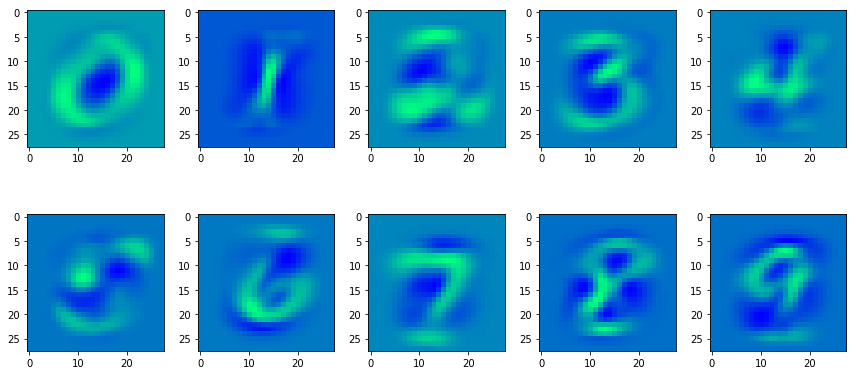

In [13]:
def plot_digit_weights(ax, digit):
    """Plot the weights from our fit fully connected network as an image."""
    digit_weigths = W.eval()[:, digit].reshape(28, -1)
    ax.imshow(digit_weigths, cmap=plt.cm.winter, interpolation="nearest")

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for digit, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax, digit)

# remove_grid_lines(axs)
plt.tight_layout()

#### 2、训练一个但隐含层的全连接神经网络（不使用正则化项）

In [14]:
n_h = 64 # 隐藏层的个数

# placeholder for input data
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# 隐藏层
# Weights
W_h = tf.Variable(tf.truncated_normal(shape=[784, n_h], stddev=0.1)) # 隐藏层个数
# Biasies
b_h = tf.Variable(0.1*tf.ones(shape=[n_h]))

# 隐藏层输出
output_hidden_layer = tf.nn.relu(tf.matmul(x,W_h) + b_h)

# 输出层
#Weights
W_o = tf.Variable(tf.truncated_normal([n_h, 10], stddev=0.1)) # 10分类
# Biasies
b_o = tf.Variable(0.1*tf.ones([10]))

# output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(output_hidden_layer,W_o) + b_o)

# loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_hat), reduction_indices=[1]))

# prediction
class_prediction = tf.argmax(y_hat,1)

# accuracy
correct_prediction = tf.equal(class_prediction, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
# train
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

n_epoch = 1000
n_iter_output = 100

epochs = []
train_accuracies = []
test_accuracies = []

# init
init = tf.global_variables_initializer()
sess.run(init)

for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        # print("Train Accuracy: {:0.2f}%".format(100*train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)
print("Test Accuracy: {:0.3f}%".format(100*sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Accuracy: 96.140%


Text(0,0.5,'Accuracy')

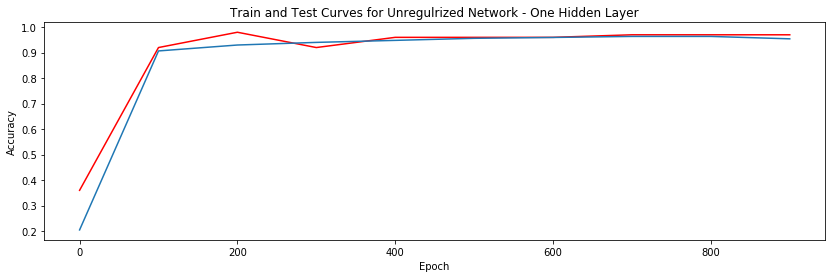

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train",c='red')
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

#### 隐藏层权重可视化

In [17]:
def plot_hidden_layer_weights(ax, tensor, layer_idx):
    """Plot the weights from our fit fully connected network as an image."""
    layer_weights = tensor.eval()[:, layer_idx].reshape(28, 28)
    ax.imshow(layer_weights, cmap=plt.cm.winter, interpolation="nearest")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

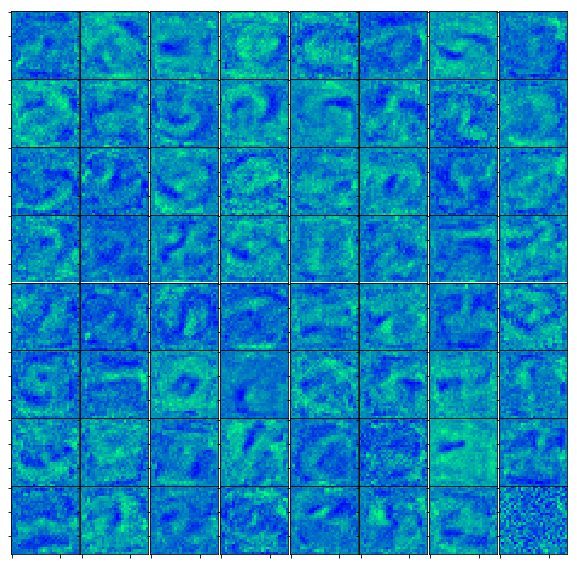

In [18]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, W_h, idx)
# remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

#### 隐藏层权重直方图

In [34]:
def plot_hidden_layer_weights_hist(ax, weights_tensor):
    hidden_layer_weights = weights_tensor.eval()[:, :].flatten()
    _ = ax.hist(hidden_layer_weights, bins=100, alpha=0.5, color="grey")
    ax.set_title("Weights in Hidden Layer")

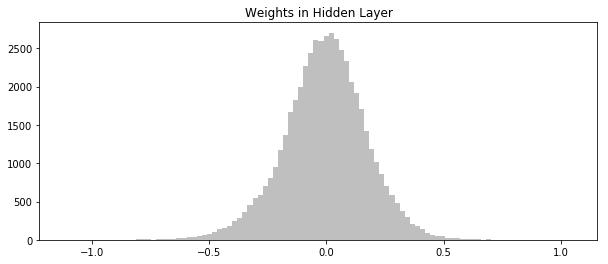

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, W_h)

#### 测试数据在隐藏层激活直方图

In [21]:
def plot_hidden_layer_activations(ax, activations_tensor):
    hidden_layer_activations = activations_tensor.eval(
        feed_dict={x: mnist.test.images, y: mnist.test.labels}).flatten()
    _ = ax.hist(hidden_layer_activations, bins=100, alpha=0.5, color="grey")

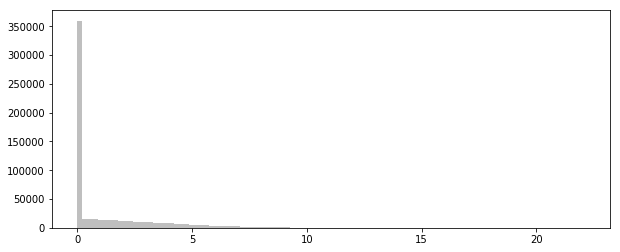

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

#### 3、训练一个但隐含层的全连接神经网络（使用$L_2$正则化项）

In [23]:
# Raw loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

# Reguarization
regularization_strength = 0.001
regularization_term = regularization_strength *(tf.nn.l2_loss(W_h) +tf.nn.l2_loss(W_o))

In [24]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy + regularization_term)

n_epoch = 1000
n_iter_output = 100

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        #print("Train Accuracy: {:0.2f}%".format(100*train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)
print("Test Accuracy: {:0.3f}%".format(100*
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Accuracy: 92.940%


Text(0,0.5,'Accuracy')

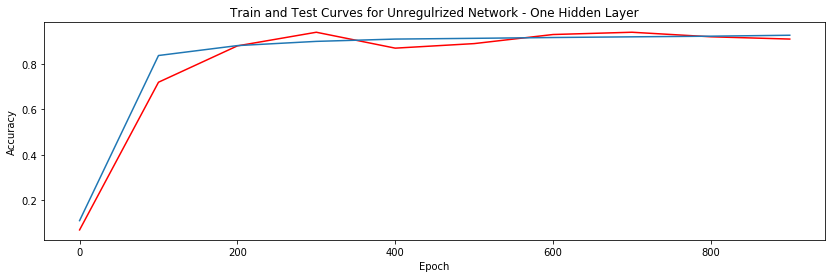

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train",c='red')
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

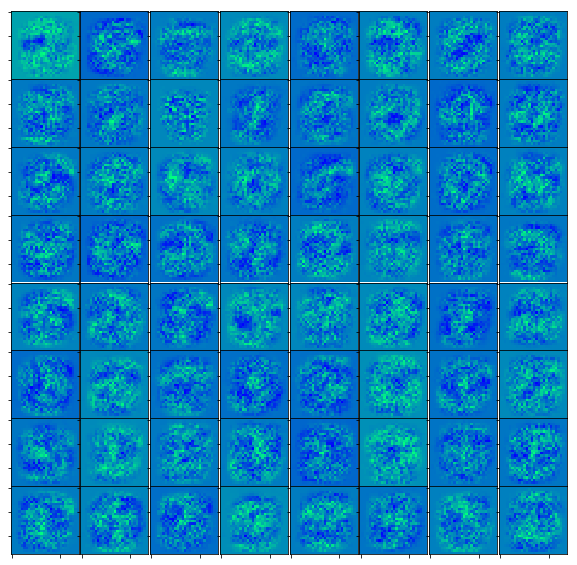

In [27]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, W_h, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

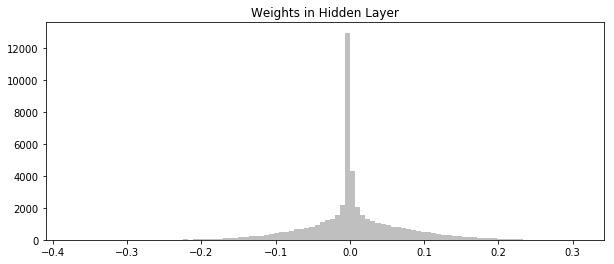

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, W_h)

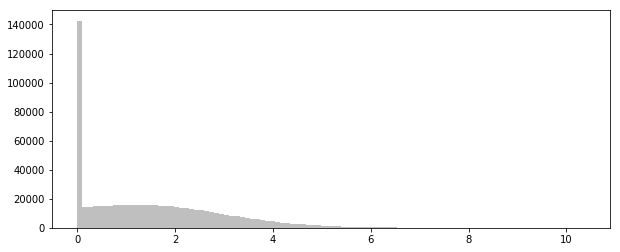

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

#### 4、训练单隐藏层神经网络（使用Dropout，不使用正则化）

In [35]:
n_h = 64 # 隐藏层的个数

# placeholder for input data
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# 隐藏层
# Weights
W_h = tf.Variable(tf.truncated_normal(shape=[784, n_h], stddev=0.1)) # 隐藏层个数
# Biasies
b_h = tf.Variable(0.1*tf.ones(shape=[n_h]))

#######################################################################
# dropout
keep_prob = tf.placeholder(tf.float32) # dropout 概率
W_h_d = tf.nn.dropout(W_h, keep_prob)

# 隐藏层输出
output_hidden_layer = tf.nn.relu(tf.matmul(x,W_h_d) + b_h)
#########################################################################

# 输出层
#Weights
W_o = tf.Variable(tf.truncated_normal([n_h, 10], stddev=0.1)) # 10分类
# Biasies
b_o = tf.Variable(0.1*tf.ones([10]))

# output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(output_hidden_layer,W_o) + b_o)

# loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_hat), reduction_indices=[1]))

# prediction
class_prediction = tf.argmax(y_hat,1)

# accuracy
correct_prediction = tf.equal(class_prediction, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [39]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)

n_epoch = 1000
n_iter_output = 100

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        #print("Train Accuracy: {:0.2f}%".format(100*train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images,
                                                 y: mnist.test.labels, keep_prob: 1.0})
        test_accuracies.append(test_accuracy)
print("Test Accuracy: {:0.3f}%".format(100*
        sess.run(accuracy, feed_dict={x: mnist.test.images, 
                                      y: mnist.test.labels, keep_prob: 1.0})))

Test Accuracy: 91.740%


Text(0,0.5,'Accuracy')

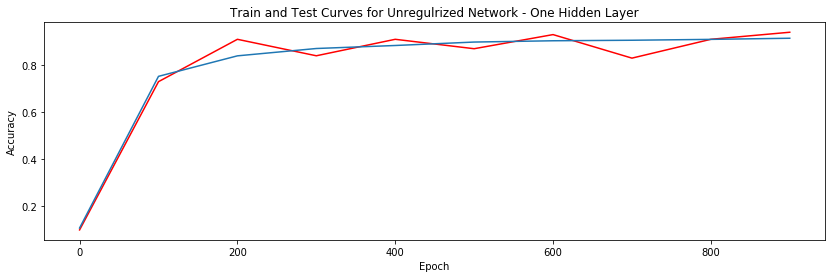

In [40]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train",c='red')
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

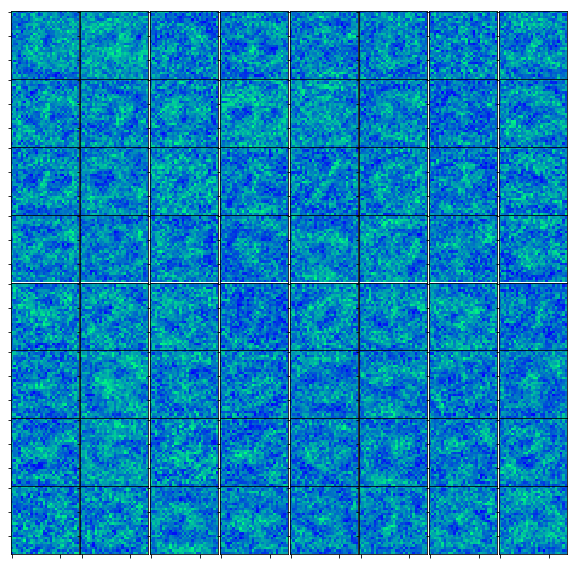

In [42]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, W_h, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

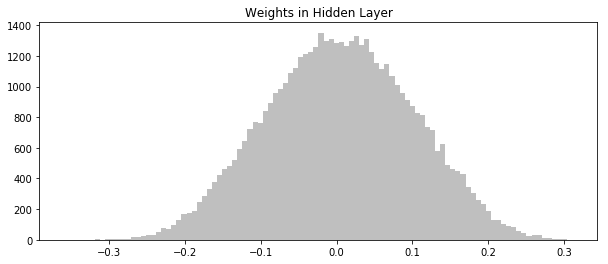

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, W_h)

In [45]:
def plot_hidden_layer_activations(ax, activations_tensor):
    hidden_layer_activations = activations_tensor.eval(
        feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}).flatten()
    _ = ax.hist(hidden_layer_activations, bins=100, alpha=0.5, color="grey")

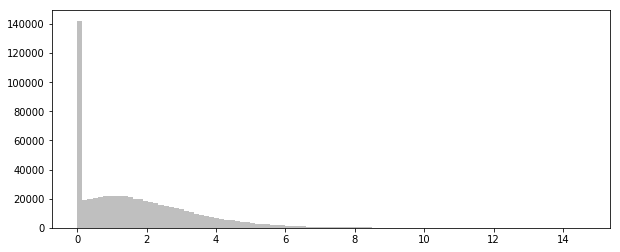

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

# 小结
1、 丢弃法只有在训练模型时使用